# Ejercicio Grupo E8FP

**Integrantes:**
- Maxim Polyak
- Jesús Gómez

## Objetivo
Dar experiencia en manejo de datos EMG y clasificación de gestos de mano, incluyendo gráficos y análisis estadístico para visualizar e interpretar los datos.

## Importación de librerías

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## Carga y preparación de datos

In [ ]:
# Carga y concatenación de los datos EMG
file_paths = glob.glob('data/HandGesture*.csv')  # Lista de las rutas de los CSV
# Cada archivo no tiene cabeceras, así que leemos con header=None
dfs = [pd.read_csv(fp, header=None) for fp in file_paths]
# Concatenamos verticalmente todos los DataFrame en uno solo
df = pd.concat(dfs, ignore_index=True)

# 3. Separación en características X y etiqueta y
# Asumimos que la última columna es la etiqueta de gesto (0-3)
X = df.iloc[:, :-1]  # Todas las columnas excepto la última → datos EMG
y = df.iloc[:, -1]   # Última columna → clase/gesto

print(f"Datos cargados: {df.shape[0]} muestras, {df.shape[1]-1} canales")

Datos cargados: 11678 muestras, 64 canales


## División del conjunto de datos (80% entrenamiento, 20% testeo)

In [4]:
# División en conjuntos de entrenamiento y prueba (80/20)
# stratify=y mantiene la proporción de clases en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Entrenamiento: {X_train.shape[0]} muestras")
print(f"Testeo: {X_test.shape[0]} muestras")

Entrenamiento: 9342 muestras
Testeo: 2336 muestras


## Análisis Exploratorio de Datos (EDA)

        mean        std    min   25%  50%   75%    max  rango
0  -0.520380  18.566709 -116.0  -9.0 -1.0   7.0  111.0  227.0
1  -0.726837  11.766878 -104.0  -4.0 -1.0   3.0   90.0  194.0
2  -0.739082   4.989944  -33.0  -3.0 -1.0   2.0   34.0   67.0
3  -0.729748   7.441675  -75.0  -4.0 -1.0   3.0   55.0  130.0
4  -0.159103  17.850402 -121.0 -10.0  0.0  10.0   92.0  213.0
..       ...        ...    ...   ...  ...   ...    ...    ...
59 -0.705343   7.384410  -74.0  -4.0 -1.0   3.0   51.0  125.0
60 -0.146686  17.841479 -103.0 -10.0  0.0  10.0  110.0  213.0
61 -0.374807  25.551082 -128.0 -14.0 -1.0  13.0  127.0  255.0
62 -1.449306  25.259736 -128.0  -6.0 -1.0   3.0  127.0  255.0
63 -0.609094  15.530091 -124.0  -8.0 -1.0   6.0  127.0  251.0

[64 rows x 8 columns]


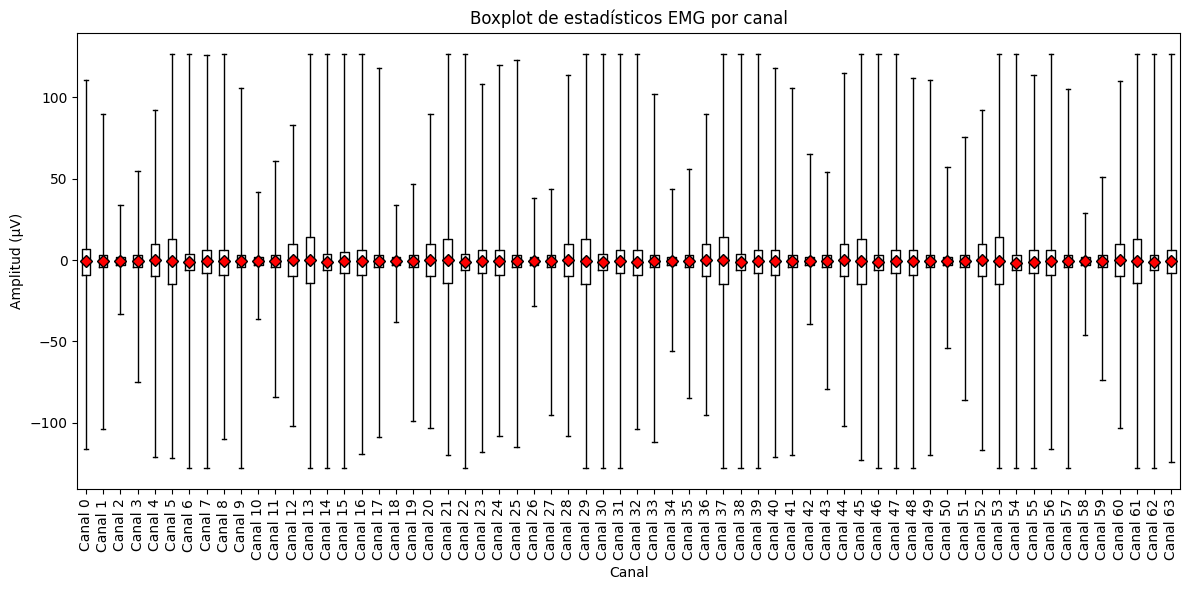

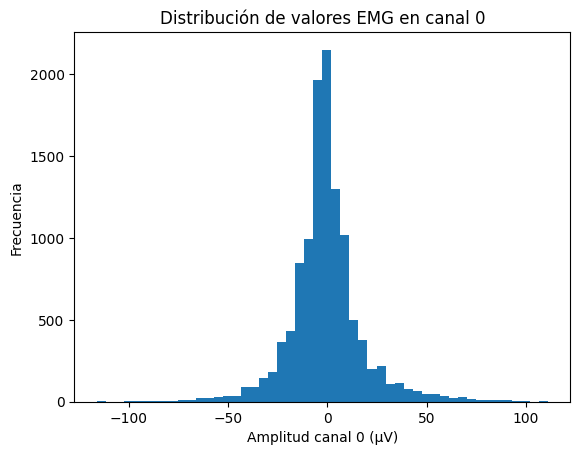

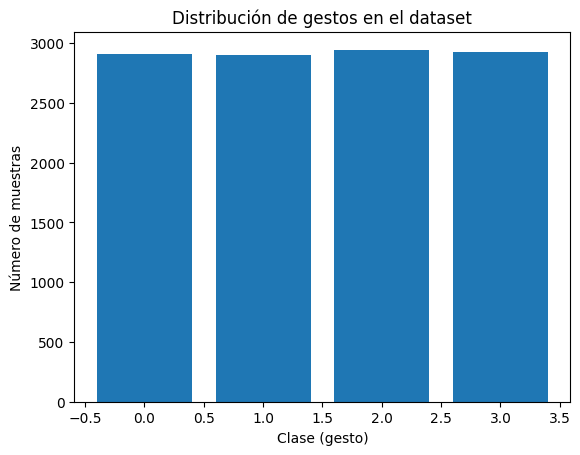

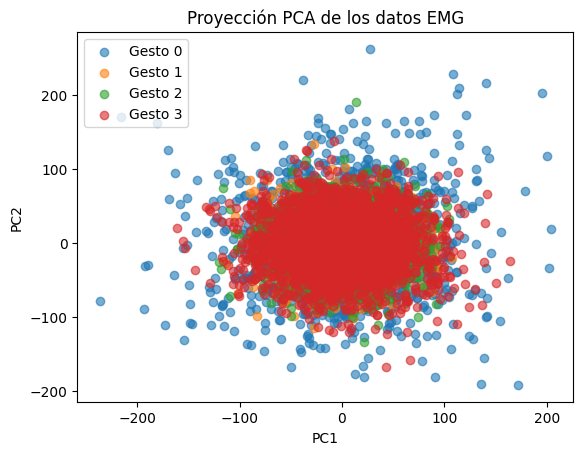

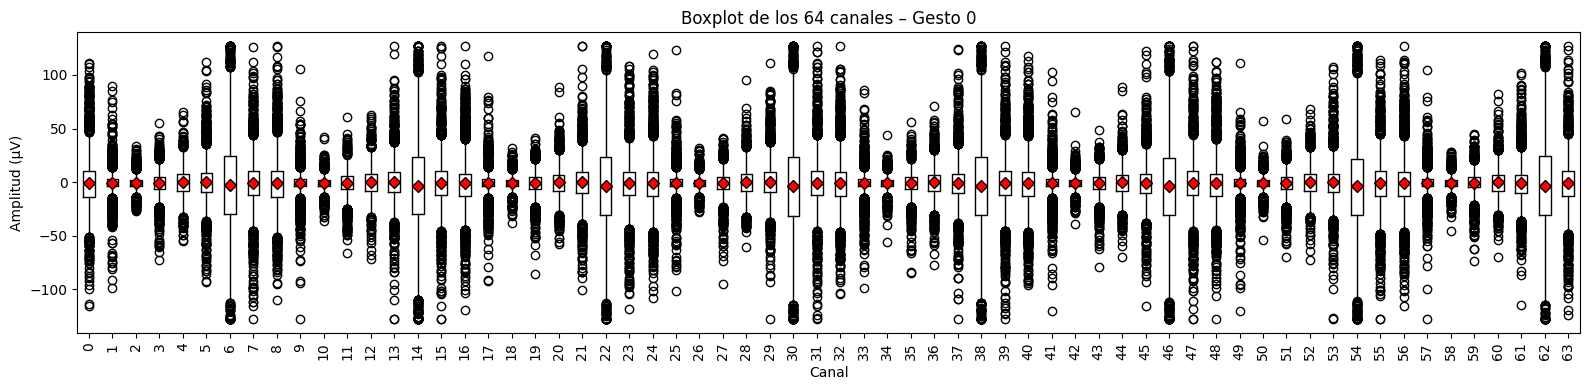

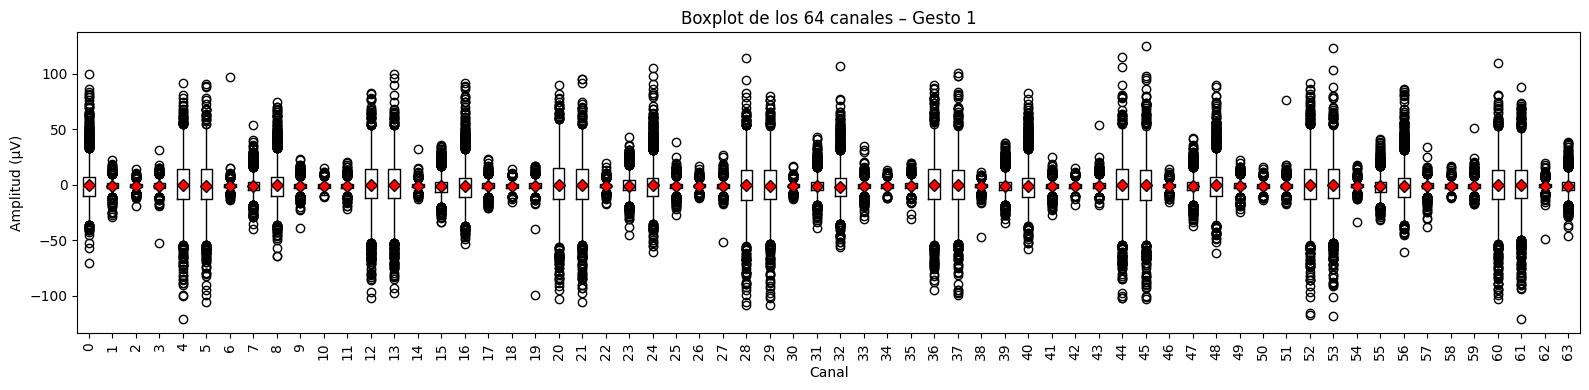

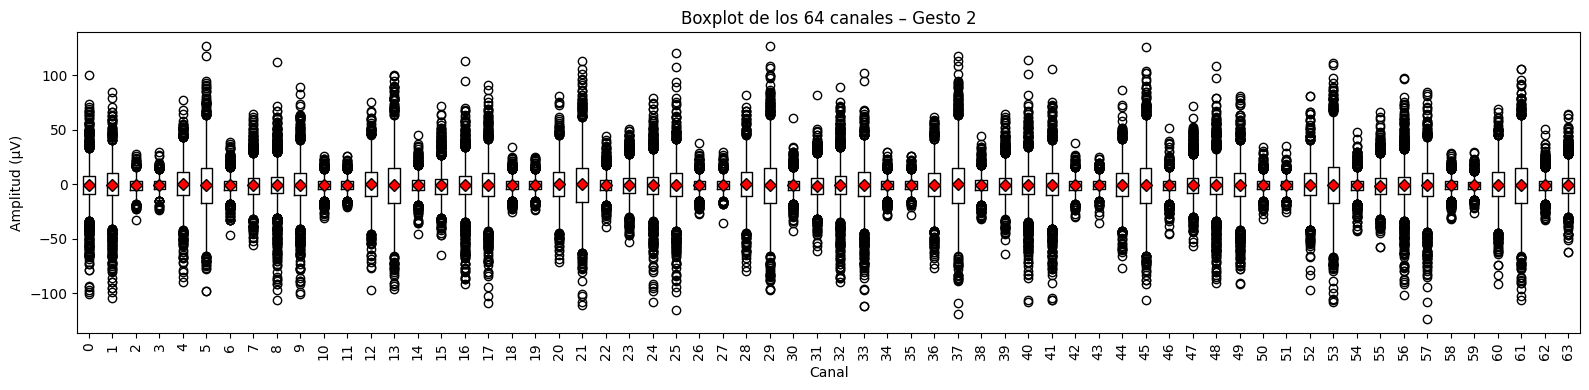

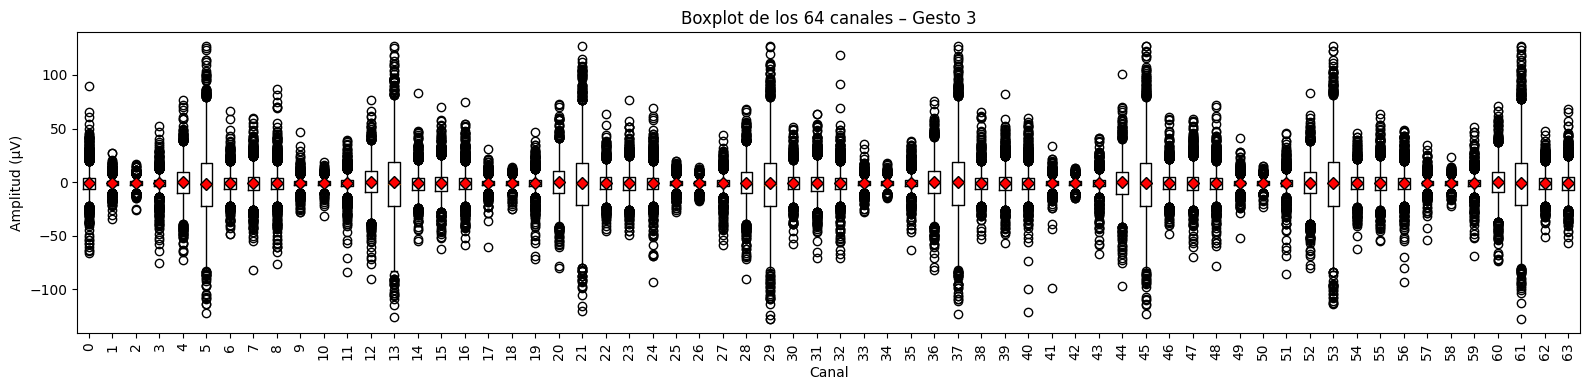

In [11]:
# Análisis Exploratorio de Datos (EDA)
# Estadísticas descriptivas por canal
desc = X.describe().T          # transpose para tener un canal/ fila
desc['rango'] = desc['max'] - desc['min']  # calculamos rango (max-min)
print(desc[['mean','std','min','25%','50%','75%','max','rango']])

# Boxplot de estadísticas calculadas
# Preparamos datos en formato que bxp() necesita
stats = []
for canal, row in desc.iterrows():
    stats.append({
        'label': f'Canal {canal}',      # etiqueta del canal
        'med': row['50%'],               # mediana (Q2)
        'q1': row['25%'],                # primer cuartil (Q1)
        'q3': row['75%'],                # tercer cuartil (Q3)
        'whislo': row['min'],            # mínimo
        'whishi': row['max'],            # máximo
        'mean': row['mean'],             # media
        'fliers': []                     # lista de outliers (no especificados)
    })
# Dibujamos boxplot mostrando media (rombo rojo)
fig, ax = plt.subplots(figsize=(12, 6))
ax.bxp(
    stats,
    showmeans=True,
    meanprops={'marker':'D','markerfacecolor':'red','markeredgecolor':'black'}
)
ax.set_xticklabels([s['label'] for s in stats], rotation=90)
ax.set_xlabel('Canal')
ax.set_ylabel('Amplitud (µV)')
ax.set_title('Boxplot de estadísticos EMG por canal')
plt.tight_layout()
plt.show()

# Histograma de un canal de ejemplo (canal 0)
plt.figure()
plt.hist(X.iloc[:,0], bins=50)
plt.xlabel('Amplitud canal 0 (µV)')
plt.ylabel('Frecuencia')
plt.title('Distribución de valores EMG en canal 0')
plt.show()

# Distribución de número de muestras por gesto
class_counts = y.value_counts().sort_index()  # cuenta por etiqueta
plt.figure()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Clase (gesto)')
plt.ylabel('Número de muestras')
plt.title('Distribución de gestos en el dataset')
plt.show()

# Proyección PCA 2D para visualización de separación de clases
pca = PCA(n_components=2)               # reducimos a 2 componentes
X_pca = pca.fit_transform(X)            # ajustamos y transformamos
plt.figure()
for cls in sorted(y.unique()):
    mask = (y == cls)
    plt.scatter(
        X_pca[mask, 0], X_pca[mask, 1],
        alpha=0.6,
        label=f'Gesto {cls}'
    )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección PCA de los datos EMG')
plt.legend()
plt.show()

# Boxplot de los 64 canales por gesto
# Para cada gesto, dibujamos un boxplot con los valores de los 64 canales
for cls in sorted(y.unique()):
    Xg = X[y == cls]
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.boxplot(
        [Xg.iloc[:, i] for i in range(Xg.shape[1])],
        showmeans=True,
        meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'black'}
    )
    ax.set_title(f'Boxplot de los {Xg.shape[1]} canales – Gesto {cls}')
    ax.set_xlabel('Canal')
    ax.set_ylabel('Amplitud (µV)')
    ax.set_xticks(range(1, Xg.shape[1]+1))
    ax.set_xticklabels(range(Xg.shape[1]), rotation=90)
    plt.tight_layout()
    plt.show()




## Conclusiones del EDA

Tras examinar los gráficos generados en la sección de Análisis Exploratorio de Datos, podemos extraer los siguientes puntos clave:

1. **Boxplot de estadísticas por canal**  
   - **Medianas cerca de cero** en todos los canales, con ligera asimetría hacia valores negativos en la mayoría.  
   - **Rangos amplios** (hasta ±120 µV) y **desviaciones típicas** de 5–20 µV, lo que indica buena variabilidad para aprendizaje.  
   - **Pocos outliers extremos** más allá de los bigotes, lo que sugiere datos relativamente limpios tras la captura.

2. **Histograma del canal 0**  
   - Distribución **leptocúrtica**: gran concentración de valores en [–5, +5] µV y colas finas.  
   - Refleja actividad muscular moderada con picos esporádicos de mayor amplitud.

3. **Distribución de gestos**  
   - **Balance casi perfecto** entre las cuatro clases (≈ 580 muestras cada una).  
   - Minimiza el sesgo en el entrenamiento y asegura que ningún gesto esté infrarrepresentado.

4. **Proyección PCA 2D**  
   - Gestos **0 y 1** forman grupos más diferenciados en el plano PC1–PC2.  
   - Gestos **2 y 3** muestran **superposición moderada**, lo que anticipa mayor dificultad de clasificación lineal entre ellos.

5. **Boxplots por gesto (64 canales)**  
   - Cada gesto mantiene la misma tendencia central (mediana ≈ 0 µV) pero con **diferencias sutiles en la dispersión** de algunos canales.  
   - Por ejemplo, ciertos canales presentan **outliers más frecuentes** en el gesto 0 y el gesto 2, indicando que esos canales captan mejor la activación muscular característica de esos movimientos.  
   - El gesto 3 tiende a exhibir **rango ligeramente menor** en varios canales frente al gesto 0, lo que puede explicar su menor recall en los clasificadores.

---

Estas observaciones validan que:
- Los datos están bien normalizados y balanceados.  
- Existen canales con mayor potencia discriminativa según el gesto.  
- Gestos con solapamiento en PCA (2 vs 3) requerirán modelos con capacidad no lineal o que estimen covarianzas por clase (p. ej. QDA).


## Entrenamiento y evaluación de modelos

In [ ]:
# Entrenamiento y evaluación de modelos
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()
}
results = {}    # para guardar accuracies
preds = {}      # para guardar predicciones
for name, model in models.items():
    # Entrenamos el modelo
    model.fit(X_train, y_train)
    # Predecimos sobre el conjunto de test
    y_pred = model.predict(X_test)
    # Calculamos métricas
    results[name] = accuracy_score(y_test, y_pred)
    preds[name] = y_pred
    print(f"Accuracy {name}: {results[name]:.4f}")
    print(classification_report(y_test, y_pred))

Accuracy Random Forest: 0.9225
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       582
           1       0.96      0.92      0.94       581
           2       0.92      0.93      0.92       589
           3       0.90      0.87      0.89       584

    accuracy                           0.92      2336
   macro avg       0.92      0.92      0.92      2336
weighted avg       0.92      0.92      0.92      2336

Accuracy LDA: 0.3390
              precision    recall  f1-score   support

           0       0.51      0.41      0.46       582
           1       0.32      0.35      0.34       581
           2       0.25      0.28      0.26       589
           3       0.32      0.31      0.32       584

    accuracy                           0.34      2336
   macro avg       0.35      0.34      0.34      2336
weighted avg       0.35      0.34      0.34      2336

Accuracy QDA: 0.9358
              precision    recall  f1-score   support

  

## Comparativa de accuracy

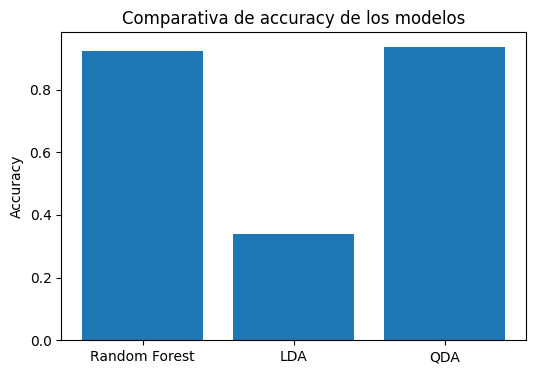

In [8]:
plt.figure(figsize=(6, 4))
plt.bar(results.keys(), results.values())
plt.ylabel('Accuracy')
plt.title('Comparativa de accuracy de los modelos')
plt.show()

## Matriz de confusión del mejor modelo (QDA)

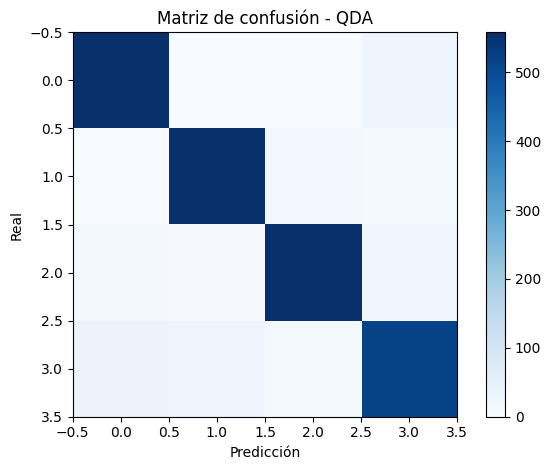

In [9]:
# Matriz de confusión del mejor modelo (QDA)
cm = confusion_matrix(y_test, preds['QDA'])
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Matriz de confusión - QDA')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.colorbar()
plt.tight_layout()
plt.show()

## Conclusiones Generales

1. **Volumen y cobertura de datos**  
   - Se cargaron **11 678 muestras** de EMG, cada una con **64 canales**, y se dividieron en **9 342** para entrenamiento y **2 336** para prueba.  
   - Esta cantidad y la repartición 80/20 garantizan suficiente variabilidad para ajustar modelos sin sobreajuste excesivo.

2. **Resultados del Análisis Exploratorio (EDA)**  
   - Las **medianas** de todos los canales rondan **−1 a 0 µV**, con **rangos** de hasta ±120 µV, lo que indica buena señal de contraste entre gestos.  
   - El **histograma** de canal 0 muestra distribución leptocúrtica, concentrando la mayoría de valores en [–5, +5] µV.  
   - La **PCA 2D** evidencia separación clara entre los gestos 0 y 1, mientras que los gestos 2 y 3 se superponen moderadamente.

3. **Desempeño de los clasificadores**  
   - **QDA** alcanza el **mejor rendimiento** (≈ 93.6 % de accuracy) al modelar covarianzas específicas por clase.  
   - **Random Forest** (≈ 92.3 %) es casi tan eficaz y ofrece mayor resiliencia frente a ruido.  
   - **LDA** (≈ 34 %) no es adecuada, pues suponer covarianza común resulta demasiado restrictivo.

4. **Análisis de errores y clases débiles**  
   - El **gesto 3** presenta el **recall más bajo** (0.89 con QDA, 0.87 con RF), reflejando el solapamiento observado en PCA con el gesto 2.  
   - Para este gesto, conviene recolectar más muestras o extraer features especializadas (p. ej. potencia en bandas de frecuencia EMG) que mejoren su discriminación.

5. **Recomendaciones**  
   - En **prototipos de baja latencia**, usar **QDA** como clasificador principal.  
   - En **entornos productivos** donde el ruido es mayor, optar por **Random Forest** por su robustez.  